In [1]:
from model import NextFramePredictor, get_next_frame_dataloader
from performance_plots import performance_boxplots

import torch
import torch.nn as nn
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.style.use("default")

import config

In [8]:
def test_performance(model, data_loader, criterion):
    loss_list = []
    model.eval()
    with torch.no_grad():
        for input, target in data_loader:
            output = model(input)
            loss = criterion(output.flatten(), target.flatten())
            loss_list.append(loss.item())
    assert len(loss_list) == 200
    return loss_list


def initialize_model(SEQ2LATENT_MODEL_PATH, LATENT2NEXTFRAME_MODEL_PATH, device):
    model = NextFramePredictor(num_channels=1, num_kernels=64,
                               kernel_size=(3, 3), padding=(1, 1), activation="relu",
                               frame_size=(64, 64), cell_type="RNN").to(device)
    if SEQ2LATENT_MODEL_PATH != "None":
        model.load_models(SEQ2LATENT_MODEL_PATH, LATENT2NEXTFRAME_MODEL_PATH, device)

    criterion = nn.MSELoss(reduction='sum')

    return model, criterion


def get_epoch_losses(parent_dir, model_dirs, epoch, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss = {}
    model_name = "best_model" if epoch == "best" else "model"

    for current_model_dir in model_dirs:
        print(f"Calculating validation loss for {current_model_dir}")
        loss[current_model_dir] = []
        for replicate_dir in tqdm(os.listdir(f'{parent_dir}/{current_model_dir}')):
            if 'LM' not in replicate_dir:
                continue

            if epoch == "best":
                for file in os.listdir(f'{parent_dir}/{current_model_dir}/{replicate_dir}'):
                    if 'best' in file:
                        epoch_nr = file.split('_')[-2]
            else:
                epoch_nr = epoch

            SEQ2LATENT_MODEL_PATH = f'{parent_dir}/{current_model_dir}/{replicate_dir}/{model_name}_epoch_{epoch_nr}_seq2latent.pth'
            LATENT2NEXTFRAME_MODEL_PATH = f'{parent_dir}/{current_model_dir}/{replicate_dir}/{model_name}_epoch_{epoch_nr}_latent2nextframe.pth'

            model, criterion = initialize_model(SEQ2LATENT_MODEL_PATH, LATENT2NEXTFRAME_MODEL_PATH, device)
            loss_list = test_performance(model, data_loader, criterion)
            loss[current_model_dir].extend(loss_list)

    return loss

In [3]:
RNN_parent_dir = f'{config.project_dir}/01_Output/Training_Output/NI_Maze_Dataset/RNN'
RNN_model_dirs = ['Pretrained_Directional', 'Pretrained_Godfrey', 'No_Pretraining', 'Shuffled_Directional']
RNN_model_names = ['DirectedProp', 'NotDirectedProp', 'NotPretrained', 'DirectedProp Shuffled']
RNN_model_designs = [{'color': '#0065bd', 'marker': 'o'},
                     {'color': '#d6a319', 'marker': 'x'},
                     {'color': '#4cc997', 'marker': 'v'},
                     {'color': '#cc323f', 'marker': '.'}]

# Validation Dataset

In [4]:
dataset_path = f"{config.project_dir}/03_Datasets/Training_Sets/NI_Dataset_Maze/validation"
val_loader = get_next_frame_dataloader(dataset_path, batch_size=1)

palette = {model: design['color'] for model, design in zip(RNN_model_dirs, RNN_model_designs)}

Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.


In [ ]:
validation_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, 0, val_loader)
pickle.dump(validation_loss, open(f'data/epoch_0_validation_loss.pkl', 'wb'))

Pretrained_Directional vs Pretrained_Godfrey: 4.6746745383106057e-45
Pretrained_Directional vs No_Pretraining: 1.9641105561042393e-123
Pretrained_Directional vs Shuffled_Directional: 1.1466145651517057e-59
Pretrained_Godfrey vs No_Pretraining: 1.9127761003682038e-204
Pretrained_Godfrey vs Shuffled_Directional: 9.56853632712229e-86
No_Pretraining vs Shuffled_Directional: 4.588859773947544


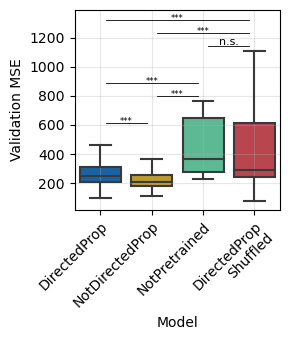

In [5]:
validation_loss = pickle.load(open(f'data/epoch_0_validation_loss.pkl', 'rb'))
performance_boxplots(validation_loss, RNN_model_dirs, RNN_model_names, palette, "figures/Figure_2/boxplots", epoch=0, set='Validation', ylim=1390, y_offset_fixed=53, y_offset_scale=0.08)

In [ ]:
validation_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, 1, val_loader)
pickle.dump(validation_loss, open(f'data/epoch_1_validation_loss.pkl', 'wb'))

Pretrained_Directional vs Pretrained_Godfrey: 4.2790933690740484e-08
Pretrained_Directional vs No_Pretraining: 4.247966967979756e-173
Pretrained_Directional vs Shuffled_Directional: 3.123831897007164e-145
Pretrained_Godfrey vs No_Pretraining: 9.657335499524894e-153
Pretrained_Godfrey vs Shuffled_Directional: 3.732724449778626e-120
No_Pretraining vs Shuffled_Directional: 0.0017247735982061905


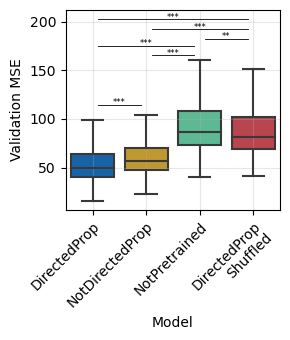

In [13]:
validation_loss = pickle.load(open(f'data/epoch_1_validation_loss.pkl', 'rb'))
performance_boxplots(validation_loss, RNN_model_dirs, RNN_model_names, palette, "figures/Figure_2/boxplots", epoch=1, set='Validation', ylim=212, y_offset_fixed=27, y_offset_scale=0.05)

In [ ]:
validation_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, "best", val_loader)
pickle.dump(validation_loss, open(f'data/epoch_best_validation_loss.pkl', 'wb'))

Pretrained_Directional vs Pretrained_Godfrey: 1.2808659492482399e-56
Pretrained_Directional vs No_Pretraining: 3.145226770784516e-20
Pretrained_Directional vs Shuffled_Directional: 2.8055181716982528e-39
Pretrained_Godfrey vs No_Pretraining: 3.0584869573855197e-12
Pretrained_Godfrey vs Shuffled_Directional: 4.634504893630708
No_Pretraining vs Shuffled_Directional: 1.5999553893236947e-09


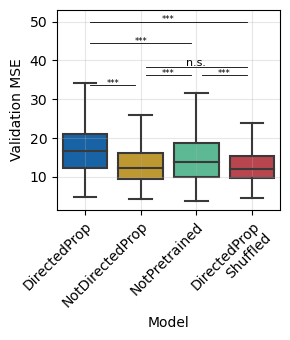

In [12]:
validation_loss = pickle.load(open(f'data/epoch_best_validation_loss.pkl', 'rb'))
performance_boxplots(validation_loss,
                     RNN_model_dirs,
                     RNN_model_names,
                     palette,
                     "figures/Figure_2/boxplots",
                     epoch="best",
                     set='Validation',
                     ylim=53,
                     y_offset_fixed=13,
                     y_offset_scale=0.2)

# Hold-out Test Dataset

In [12]:
dataset_path = f"{config.project_dir}/03_Datasets/Training_Sets/NI_Dataset_Maze/test"
test_loader = get_next_frame_dataloader(dataset_path, batch_size=1)

palette = {model: design['color'] for model, design in zip(RNN_model_dirs, RNN_model_designs)}

Loading file 1 of 200...
Loading file 101 of 200...
Dataset with 200 samples loaded.


In [ ]:
test_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, 0, test_loader)
pickle.dump(test_loss, open(f'data/epoch_0_test_loss.pkl', 'wb'))

Pretrained_Directional vs Pretrained_Godfrey: 7.169530824118296e-20
Pretrained_Directional vs No_Pretraining: 2.2266811540357873e-231
Pretrained_Directional vs Shuffled_Directional: 3.3810054000842758e-108
Pretrained_Godfrey vs No_Pretraining: 3.105133121434398e-260
Pretrained_Godfrey vs Shuffled_Directional: 2.6251876474314876e-109
No_Pretraining vs Shuffled_Directional: 1.315275582923515


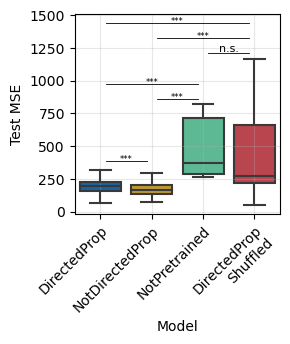

In [17]:
test_loss = pickle.load(open(f'data/epoch_0_test_loss.pkl', 'rb'))
performance_boxplots(test_loss, RNN_model_dirs, RNN_model_names, palette, "figures/Figure_2/boxplots", epoch=0, set='Test', ylim=1510, y_offset_fixed=75)

In [ ]:
test_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, 1, test_loader)
pickle.dump(test_loss, open(f'data/epoch_1_test_loss.pkl', 'wb'))

Pretrained_Directional vs Pretrained_Godfrey: 1.0071659906315686e-32
Pretrained_Directional vs No_Pretraining: 9.053440337618563e-225
Pretrained_Directional vs Shuffled_Directional: 1.8537055233921974e-191
Pretrained_Godfrey vs No_Pretraining: 1.5676039388875854e-150
Pretrained_Godfrey vs Shuffled_Directional: 8.061621174119575e-119
No_Pretraining vs Shuffled_Directional: 0.0014284543735772369


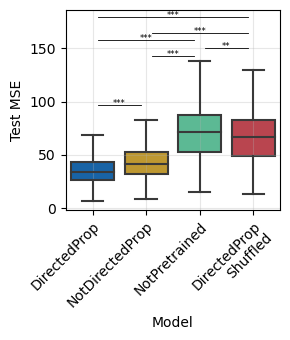

In [20]:
test_loss = pickle.load(open(f'data/epoch_1_test_loss.pkl', 'rb'))
performance_boxplots(test_loss, RNN_model_dirs, RNN_model_names, palette, "figures/Figure_2/boxplots", epoch=1, set='Test', ylim=186, y_offset_fixed=10)

Calculating validation loss for Pretrained_Directional


100%|██████████| 6/6 [02:09<00:00, 21.58s/it]


Calculating validation loss for Pretrained_Godfrey


100%|██████████| 5/5 [02:23<00:00, 28.63s/it]


Calculating validation loss for No_Pretraining


100%|██████████| 6/6 [30:32<00:00, 305.48s/it]


Calculating validation loss for Shuffled_Directional


100%|██████████| 5/5 [03:25<00:00, 41.09s/it]

Pretrained_Directional vs Pretrained_Godfrey: 1.2488618162170951e-101
Pretrained_Directional vs No_Pretraining: 7.1188182704521004e-34
Pretrained_Directional vs Shuffled_Directional: 1.4592667717057079e-66
Pretrained_Godfrey vs No_Pretraining: 1.0789584800560137e-25
Pretrained_Godfrey vs Shuffled_Directional: 5.087387857202275
No_Pretraining vs Shuffled_Directional: 5.751590660643269e-23


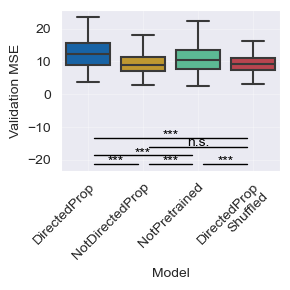

In [15]:
test_loss = get_epoch_losses(RNN_parent_dir, RNN_model_dirs, "best", test_loader)
pickle.dump(test_loss, open(f'data/epoch_best_test_loss.pkl', 'wb'))

Pretrained_Directional vs Pretrained_Godfrey: 1.2488618162170951e-101
Pretrained_Directional vs No_Pretraining: 7.1188182704521004e-34
Pretrained_Directional vs Shuffled_Directional: 1.4592667717057079e-66
Pretrained_Godfrey vs No_Pretraining: 1.0789584800560137e-25
Pretrained_Godfrey vs Shuffled_Directional: 5.087387857202275
No_Pretraining vs Shuffled_Directional: 5.751590660643269e-23


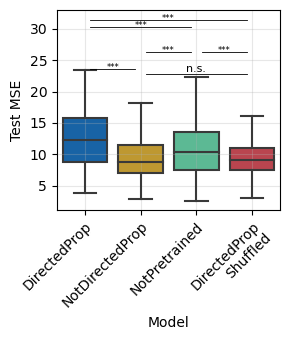

In [33]:
test_loss = pickle.load(open(f'data/epoch_best_test_loss.pkl', 'rb'))
performance_boxplots(test_loss, RNN_model_dirs, RNN_model_names, palette, "figures/Figure_2/boxplots", epoch="best", set='Test', ylim=33, y_offset_fixed=3.8, y_offset_scale=0.15)